### Importing

In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import concurrent.futures
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from multiprocessing import Pool
import multiprocessing
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import umap

model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2', device=torch.device('mps'))

/Users/arminnoqteh/anaconda3/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [20]:
import scienceplots
# turn back all configurations to default
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use(['science'])

### Labels

In [7]:
topics = ['سیاسی','اقتصادی','اجتماعی']
sentiments = ['احساس مثبت','احساس منفی']
tone = ['احساسی','منطقی']
rights = ['حقوق بشر','حقوق کودکان','حقوق زنان','حقوق مدنی','حقوق سیاسی','حقوق اقتصادی','حقوق اجتماعی']
names = ['رئیس‌جمهور','رهبر','دولت']
other_labels = ['نابرابری و تبعیض جنسیتی', 'تحریم‌ها', 'توافق هسته‌ای']

### Datasets

It is now assumed that your dataset has gone through some kind of cleaning pipeline and its column names are: Title, Time, Body, Abstract, Source

In [ ]:
df = pd.read_csv('news.csv')
news_embeddings = model.encode(df['Body'].values, show_progress_bar=True)
sentiments_embeddings = model.encode(sentiments, show_progress_bar=True)
tone_embeddings = model.encode(tone, show_progress_bar=True)
rights_embeddings = model.encode(rights, show_progress_bar=True)
names_embeddings = model.encode(names, show_progress_bar=True)
other_labels_embeddings = model.encode(other_labels, show_progress_bar=True)
topic_embeddings = model.encode(topics, show_progress_bar=True)

### Methods

#### Calculate Similarity

In [8]:
def calculate_similarity(labels, texts, label_embeddings=None, text_embeddings=None):
    if label_embeddings is None:
        label_embeddings = model.encode(labels,show_progress_bar=True)
    if text_embeddings is None:
        text_embeddings = model.encode(texts,True)
    
    # make a dataframe with labels as columns and their corresponsing score as rows
    scores = pd.DataFrame(cosine_similarity(text_embeddings, label_embeddings), columns=labels)

    return scores

In [9]:
def add_labels_scores(df, labels, label_embeddings=None, text_embeddings=None):
    scores = calculate_similarity(labels, df['Body'], label_embeddings, text_embeddings)
    df.reset_index(drop=True, inplace=True)
    df = pd.concat([df, scores], axis=1)
    return df

def add_label(df, labels, label_embeddings=None, text_embeddings=None, label=None):
    scores = calculate_similarity(labels, df['Body'], label_embeddings, text_embeddings)
    df.reset_index(drop=True, inplace=True)
    df[label] = scores.idxmax(axis=1)
    return df

#### Extract Keywords

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from hazm import SentenceTokenizer, WordTokenizer, POSTagger, Lemmatizer
from hazm.utils import stopwords_list

word_tokenize = WordTokenizer().tokenize
sent_tokenize = SentenceTokenizer().tokenize
lemmatizer = Lemmatizer()
pos_tag = POSTagger('/hazm_models/pos_tagger.model')

from tqdm import tqdm

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'
    elif tag.startswith('V'):
        return 'v'
    elif tag.startswith('N'):
        return 'n'
    elif tag.startswith('R'):
        return 'r'
    else:
        return 'n'

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import Parallel, delayed
from collections import Counter
import dill
from multiprocessing import Pool

def extract_keywords(texts, num_keywords):
# Preprocess with progress bar without any multiprocessing, just give me a break!
    preprocessed_texts = Parallel(n_jobs=-1, backend='threading')(delayed(preprocess_text)(text) for text in tqdm(texts))

    # Combine all texts into one
    combined_text = ' '.join(preprocessed_texts)

    vectorizer = TfidfVectorizer(stop_words=stopwords_list())
    tfidf_matrix = vectorizer.fit_transform([combined_text])
    feature_names = vectorizer.get_feature_names_out()

    feature_index = tfidf_matrix.nonzero()[1]
    tfidf_scores = zip(feature_index, [tfidf_matrix[0, x] for x in feature_index])
    features_scores = [(feature_names[i], s) for (i, s) in tfidf_scores]
    sorted_scores = sorted(features_scores, key=lambda x: x[1], reverse=True)

    return [word for word,_ in sorted_scores[:num_keywords]]


def preprocess_text(text):
    sentences = sent_tokenize(text)
    lemmatized_words = []
    for sentence in sentences:
        words = word_tokenize(sentence)
        lemmas = [lemmatizer.lemmatize(word) for word in words]
        pos_tags = pos_tag.tag(lemmas)
        lemmatized_words.extend([lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags])

    return ' '.join(lemmatized_words)


### Labeling the df

In [13]:
df = add_labels_scores(df, rights, rights_embeddings,news_embeddings)
df = add_labels_scores(df, names, names_embeddings,news_embeddings)
df = add_labels_scores(df, other_labels, other_labels_embeddings,news_embeddings)
df = add_label(df, sentiments, sentiments_embeddings, news_embeddings, 'Sentiment')
df = add_label(df, tone, tone_embeddings, news_embeddings, 'Tone')
df = add_label(df, topics, topic_embeddings, news_embeddings, 'Topic')

### Clustering

#### Evaluation

In [3]:
from sklearn import metrics

def evaluate_clustering(data, labels):
    davies_bouldin_score = metrics.davies_bouldin_score(data, labels)
    calinski_harabasz_score = metrics.calinski_harabasz_score(data, labels)
    return davies_bouldin_score, calinski_harabasz_score

#### Plotting

In [4]:
def plot_clusters(labels, reduced_data_pca, reduced_data_umap):
    # Plot the clusters
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.title('PCA')
    plt.scatter(reduced_data_pca[:, 0], reduced_data_pca[:, 1], c=labels, s=20, alpha=0.7)
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title('UMAP')
    plt.scatter(reduced_data_umap[:, 0], reduced_data_umap[:, 1], c=labels, s=20, alpha=0.7)
    plt.colorbar()

    return plt

#### Dim Reduction

In [6]:
def dimension_reduction(data):
    # Perform dimension reduction using PCA
    pca = PCA(n_components=2)
    reduced_data_pca = pca.fit_transform(data)

    # Use UMAP to reduce dimensionality
    reducer = umap.UMAP()
    reduced_data_umap = reducer.fit_transform(data)

    return reduced_data_pca, reduced_data_umap

news_reduced_pca, news_reduced_umap = dimension_reduction(news_embeddings)

/Users/arminnoqteh/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(3.491489913796092, 3876.339577860523)


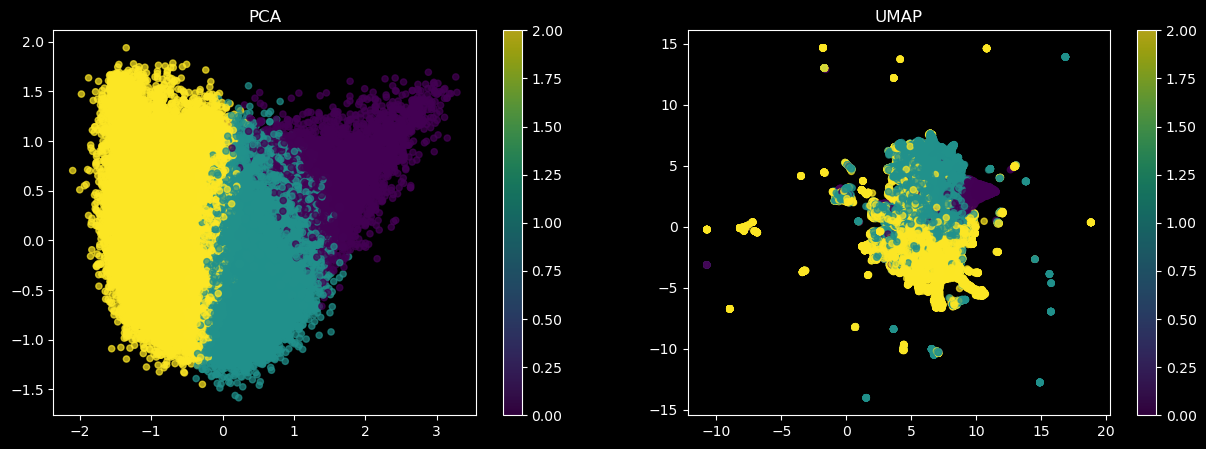

In [7]:
from sklearn.cluster import MiniBatchKMeans

def minibatchkmeans(data, n_clusters, batch_size=100, max_iter=100):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, max_iter=max_iter)
    labels = kmeans.fit_predict(data)
    print(evaluate_clustering(data, labels))
    return labels

labels = minibatchkmeans(news_embeddings, 3)
plt = plot_clusters(labels, news_reduced_pca, news_reduced_umap)
# plt.savefig('clustering.pdf')
plt.show()

#### Cluster Keyword Extraction

In [ ]:
# df['clustering_labels'] = labels
# Group the texts by cluster
grouped = df.sample(frac=.1, random_state = 42).groupby('clustering_labels')['Body']

# Extract keywords for each cluster
keywords = grouped.apply(lambda x: extract_keywords(x, 42))

# Print the keywords
for i, cluster_keywords in enumerate(keywords):
    print(f'Cluster {i} keywords: {cluster_keywords}')


#### Optimizing Clustering & DBSCAN

In [ ]:
def optimize_n(data):
    for i in range(2, 25):
        labels = minibatchkmeans(data, i)

optimize_n(news_embeddings)

In [ ]:
import matplotlib.pyplot as plt


def elbow_method(data):
    # Define the range of cluster numbers to try
    k_values = range(1, 50)

    # Initialize an empty list to store the sum of squared distances for each cluster number
    sse = []

    # Iterate over each cluster number and calculate the sum of squared distances
    for k in k_values:
        kmeans = MiniBatchKMeans(n_clusters=k, batch_size=100, max_iter=100)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)

    # Plot the sum of squared distances for each cluster number
    plt.plot(k_values, sse)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of Squared Distances')
    plt.title('Elbow Method')
    plt.show()

elbow_method(news_embeddings)

In [ ]:
from sklearn.cluster import DBSCAN


def optimize_dbscan(data):
    # Define the range of parameter values to optimize
    eps_values = [0.1, 0.5, 1.0, 1.5]
    min_samples_values = [2, 5, 10, 20]

    best_score = -1
    best_eps = None
    best_min_samples = None

    # Iterate over the parameter values and find the best combination
    for eps in eps_values:
        for min_samples in min_samples_values:
            # Create a DBSCAN instance with the current parameter values
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            
            # Fit the DBSCAN model to the data
            labels = dbscan.fit_predict(data)
            
            # Calculate the davies_bouldin_score
            score = metrics.davies_bouldin_score(data, labels)
            
            # Check if the current combination of parameters gives a better score
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

    # Print the best parameter values and the corresponding silhouette score
    print("Best eps:", best_eps)
    print("Best min_samples:", best_min_samples)
    print("Best silhouette score:", best_score)

optimize_dbscan(news_embeddings)

In [ ]:
def dbscan(data, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)
    print(evaluate_clustering(data, labels))
    return labels

labels = dbscan(news_embeddings, 1.5, 20)
plt = plot_clusters(labels, news_reduced_pca, news_reduced_umap)
plt.show()

### Time Series Analysis

In [48]:
mappings = {'احساس مثبت': 'Positive', 'احساس منفی': 'Negative', 'احساسی': 'Emotional', 'منطقی': 'Logical', 'سیاسی': 'Political', 'اقتصادی': 'Economic', 'اجتماعی': 'Social'}
df['Sentiment'] = df['Sentiment'].map(mappings)
df['Tone'] = df['Tone'].map(mappings)
df['Topic'] = df['Topic'].map(mappings)

In [51]:
column_names_mappings = {'دولت': 'Government','رئیس‌جمهور': 'President', 'رهبر': 'Leader', 'حقوق بشر': 'Human Rights', 'حقوق کودکان': 'Children Rights', 'حقوق زنان': 'Women Rights', 'حقوق مدنی': 'Civil Rights', 'حقوق سیاسی': 'Political Rights', 'حقوق اقتصادی': 'Economic Rights', 'حقوق اجتماعی': 'Social Rights', 'نابرابری و تبعیض جنسیتی': 'Gender Inequality', 'تحریم‌ها': 'Sanctions', 'توافق هسته‌ای': 'Nuclear Deal'}
df = df.rename(columns=column_names_mappings)

#### Analyze Categorical Trend

In [14]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
def analyze_categorical_trend(df, categorical_columns, time_column, source_column, source):
    # Filter for only the specified source
    filtered_df = df[df[source_column] == source]

    # Convert time_column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(filtered_df[time_column]):
        filtered_df[time_column] = pd.to_datetime(filtered_df[time_column])

    # Group the filtered DataFrame by the categorical columns and time periods
    filtered_df['WeeklyPeriods'] = filtered_df[time_column].dt.to_period('M')

    # Convert categorical columns to category type and create a new column for each category
    categorical_columns_labels = []
    for column in categorical_columns:
        filtered_df[column] = filtered_df[column].astype('category')
        filtered_df = pd.get_dummies(filtered_df, columns=[column], prefix=column)
        categorical_columns_labels.extend(filtered_df.filter(like=column).columns.tolist())

    grouped_df = filtered_df.groupby('WeeklyPeriods')[categorical_columns_labels].sum()
    

    return grouped_df


#### Analyze Numerical Trend

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_numerical_trend(df, numerical_columns, time_column, source_column, source):
    # Convert time_column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df[time_column]):
        df[time_column] = pd.to_datetime(df[time_column])
    
    # Combine dates into monthly periods
    df['MonthlyPeriod'] = df[time_column].dt.to_period('M')

    # Filter for only the specified source
    filtered_df = df[df[source_column] == source]
    
    # Group the DataFrame by the MonthlyPeriod and calculate the mean of the numerical columns
    grouped_df = filtered_df.groupby('MonthlyPeriod')[numerical_columns].mean()

    # Plot the grouped DataFrame
    grouped_df.plot(kind='line', figsize=(10, 6))
    plt.title(f'{numerical_columns} Trend for {source}')
    plt.xlabel('Date')
    plt.ylabel('Mean')
    
    return grouped_df

#### Pivot Table

In [65]:
def pivot_table(df, time_column, columns, values, aggfunc, index_column='MonthlyPeriod'):
    # Convert time_column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df[time_column]):
        df[time_column] = pd.to_datetime(df[time_column])

    # Combine dates into monthly periods
    df['MonthlyPeriod'] = df[time_column].dt.to_period('M')
    # df = df[df['Source'].isin(['Tasnim'])]
    # Create a pivot table
    pivot_table = df.pivot_table(index=index_column, columns=columns, values=values, aggfunc=aggfunc)

    # Define color mappings for sentiments
    color_sentiments = {'Positive': 'green', 'Negative': 'red'}

    fig, axes = plt.subplots(len(columns), 1, figsize=(10, 6 * len(columns)))

    for i, column in enumerate(pivot_table.columns.levels[0]):
        pivot_table[column].plot(kind='line', ax=axes[i],)   # color=color_sentiments
        axes[i].set_title(f'Trend for {column}')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Mean')

    # plt.tight_layout()
    return pivot_table, plt

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

def seasonality_analysis(data, time_column, value_column):
    # Convert time_column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(data[time_column]):
        data[time_column] = pd.to_datetime(data[time_column])
    
    # Set time_column as the index of the DataFrame
    data.set_index(time_column, inplace=True)
    
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(data[value_column], model='additive')
    
    # Get the trend, seasonal, and residual components
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plot the components
    decomposition.plot()
    
    # Return the components
    return trend, seasonal, residual

In [ ]:
from sklearn.ensemble import IsolationForest

def detect_anomalies(data, contamination=0.1):
    # Create an instance of the Isolation Forest algorithm
    model = IsolationForest(contamination=contamination)
    
    # Fit the model to the data
    model.fit(data)
    
    # Predict the anomalies
    anomalies = model.predict(data)
    
    # Return the anomaly predictions
    return anomalies

detect_anomalies()

### Results

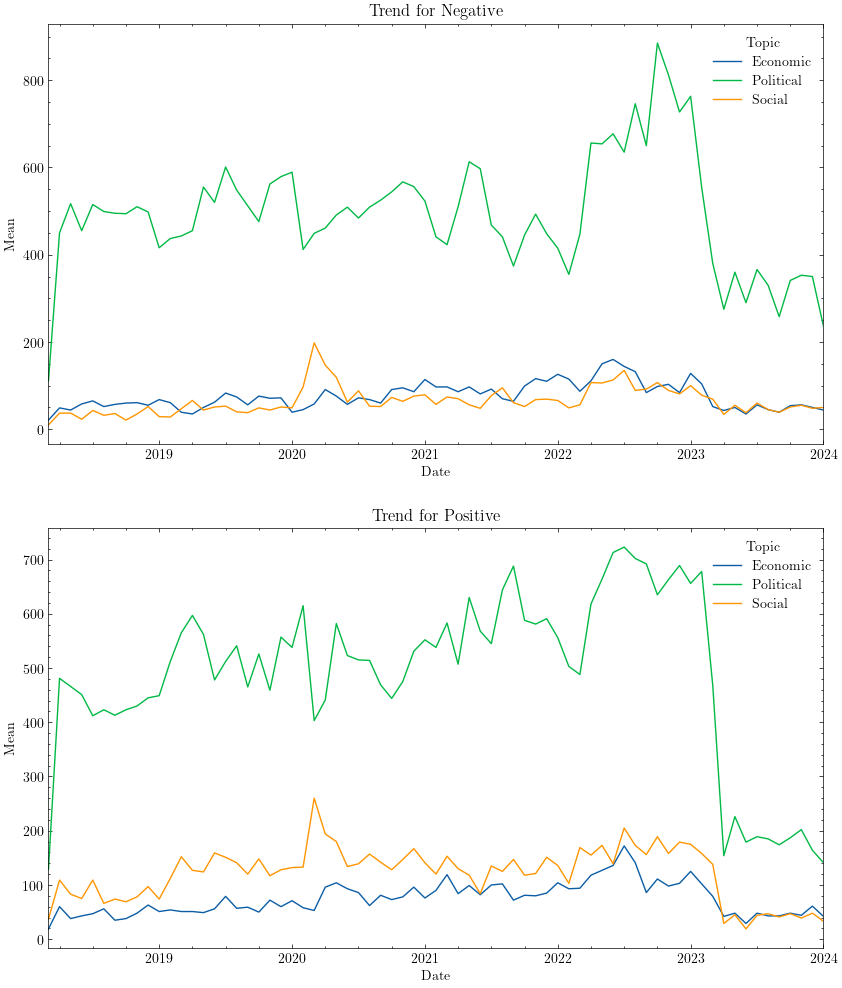

In [66]:
topic_sentiment, plt = pivot_table(df, 'Time', ['Sentiment', 'Topic'], 'Abstract', 'count')
plt.show()

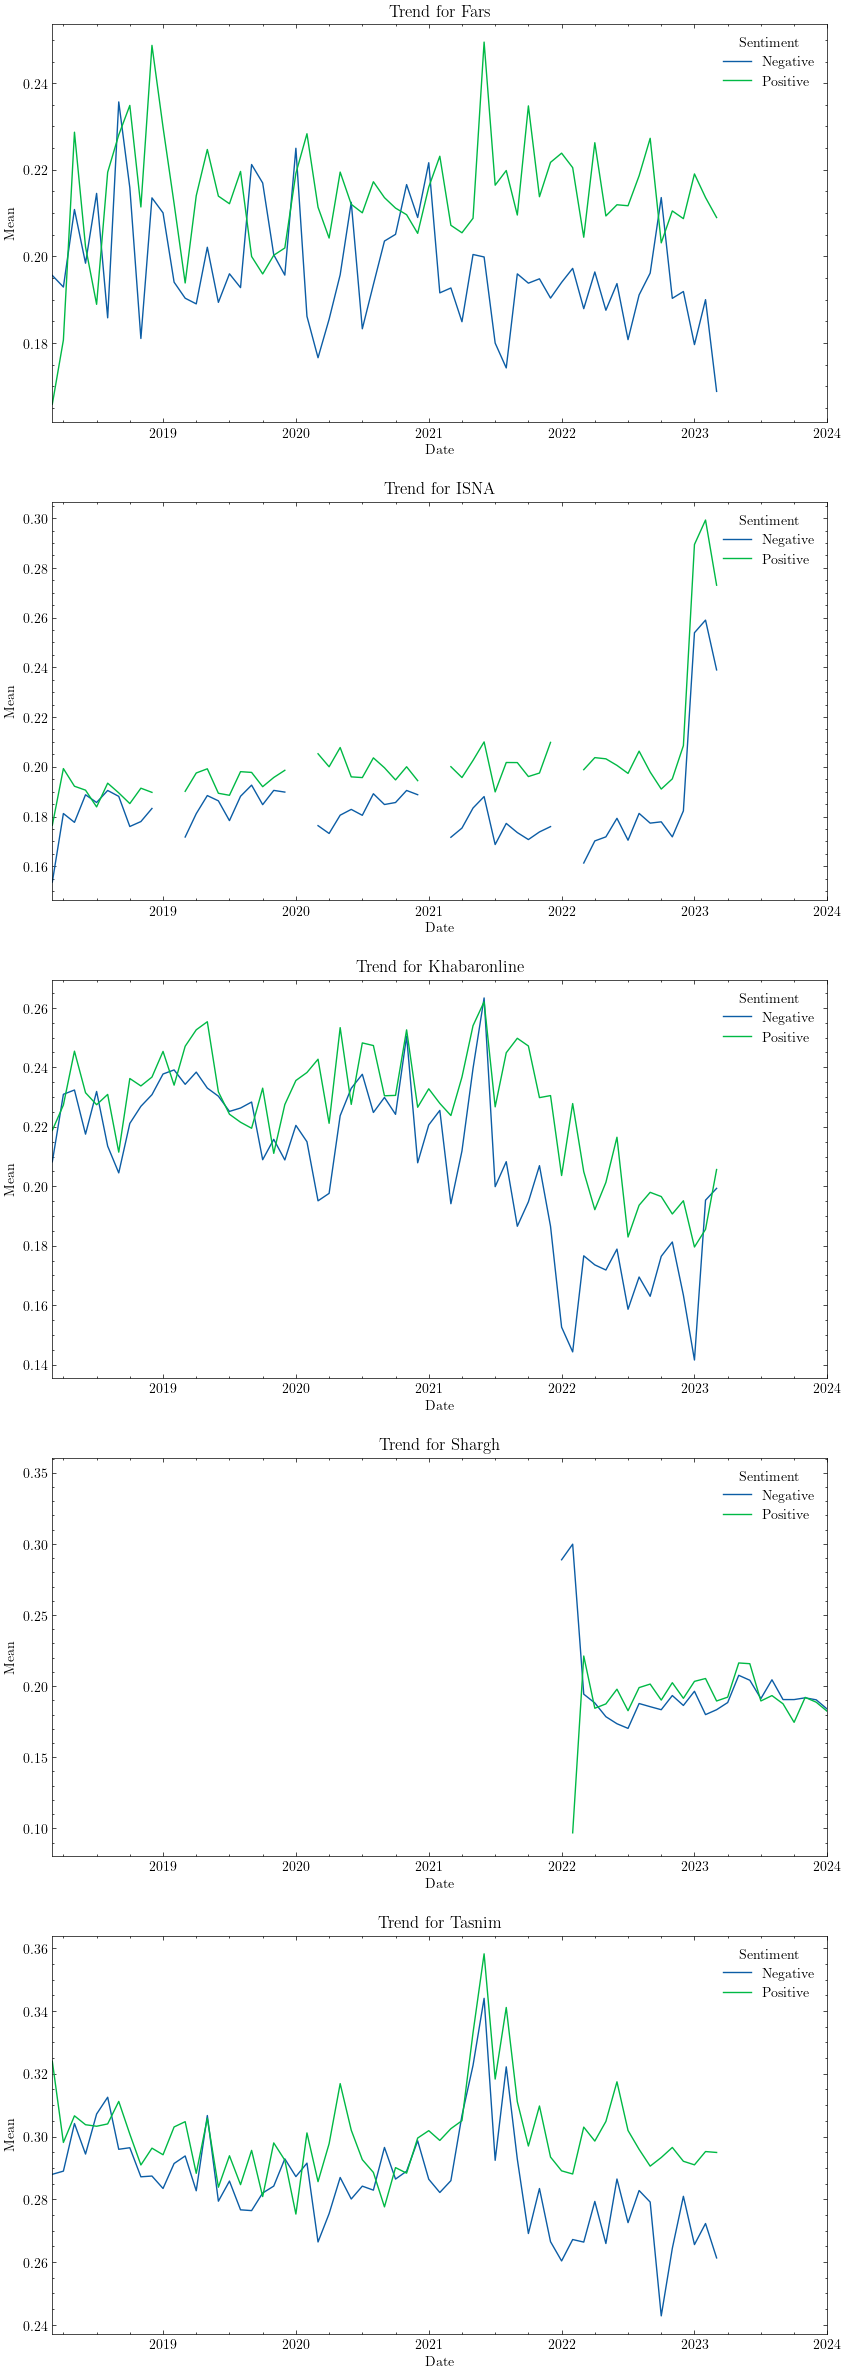

In [57]:
president_sentiment, plt = pivot_table(df, 'Time', ['Source', 'Sentiment'], 'President', 'mean')
plt.show()

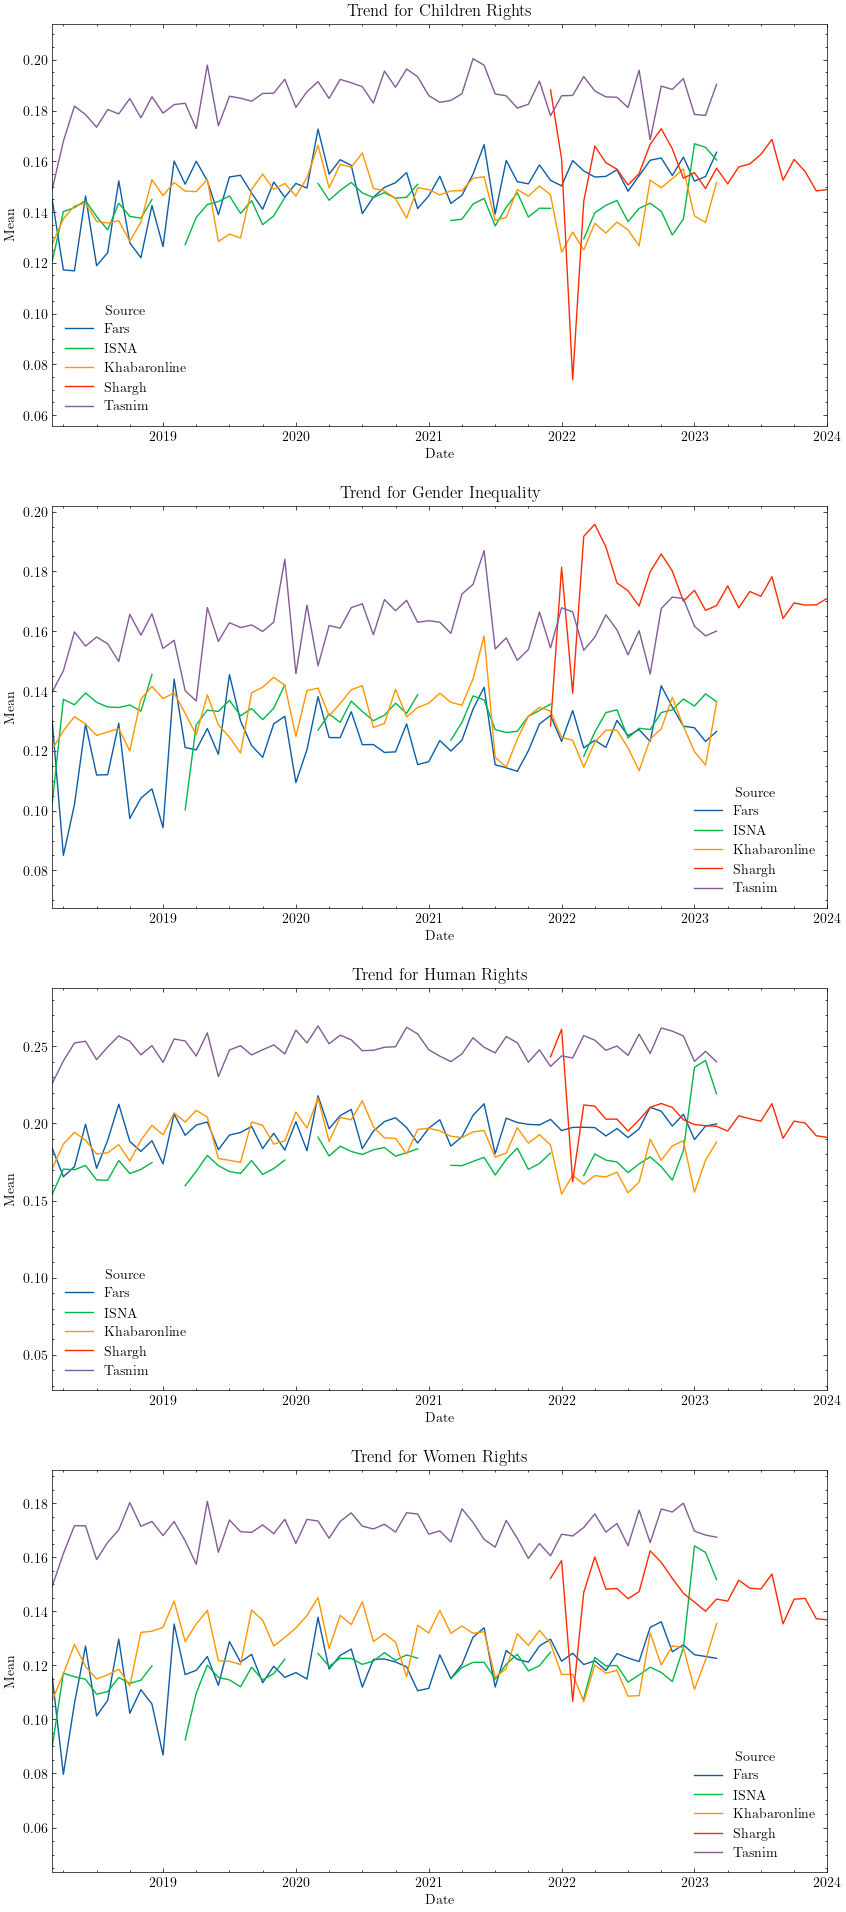

In [ ]:
rights, plt = pivot_table(df, 'Time', 'Source', ['Women Rights', 'Gender Inequality','Human Rights', 'Children Rights'],'mean')
plt.show()